In [1]:
from networklib import networkcon 
import pandas as pd
import math
import folium
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, LinearRing, Polygon

%matplotlib notebook

In [2]:
def distance(origin, destination):

    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    
    return d*1000

In [3]:
def latlonscale(lat, lon):
    return (distance((lat+0.5,lon),(lat-0.5,lon)),distance((lat,lon+0.5),(lat,lon-0.5)))

In [4]:
nw = networkcon.networkcon("database/network.db")
nw.connect()

2018-07-04 18:51:25.030836 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\networkcon.py - conected to db...
2018-07-04 18:51:25.030836 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\networkcon.py - fetching queries from C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries


In [5]:
network= nw.get_simple("network_query.sql")
network.head()

2018-07-04 18:51:25.860794 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\network_query.sql


,Cellid,CellName,Siteid,SiteName,Frequency,Power,Azimuth,CellParam1,CellParam2,CellParam3,CellParam4,CellParam5,CellParam6,CellParam7,CellParam8,CellParam9,KPI_x,Longitude,Latitude
0,4960,Cell_4960,1704,Site_1704,Layer1,42,50,AA,250,549,31,71,68,39,9,11,2.901021,14.583308,52.316767
1,4961,Cell_4961,1704,Site_1704,Layer1,42,120,BA,226,544,30,26,13,59,27,81,2.901021,14.583308,52.316767
2,4962,Cell_4962,1704,Site_1704,Layer1,42,250,CB,424,431,93,92,45,56,41,60,2.867531,14.583308,52.316767
3,5082,Cell_5082,1742,Site_1742,Layer1,42,110,CB,124,177,29,73,98,94,21,12,2.867531,14.342583,52.349111
4,5083,Cell_5083,1742,Site_1742,Layer1,42,220,AA,367,463,39,51,85,10,39,3,2.867531,14.342583,52.349111


In [6]:
def cell2line(lat, lon, azimuth, radius):
    '''Creates a LineString object in thre direction of 
    azimuth and length of radius'''
    
    lat_scale, lon_scale = latlonscale(lat,lon)
    
    return LineString([(lon, lat)
                    ,(lon + radius*math.cos(azimuth*math.pi/180)/lon_scale
                    ,lat + radius*math.sin(azimuth*math.pi/180)/lat_scale)])

<IPython.core.display.Javascript object>


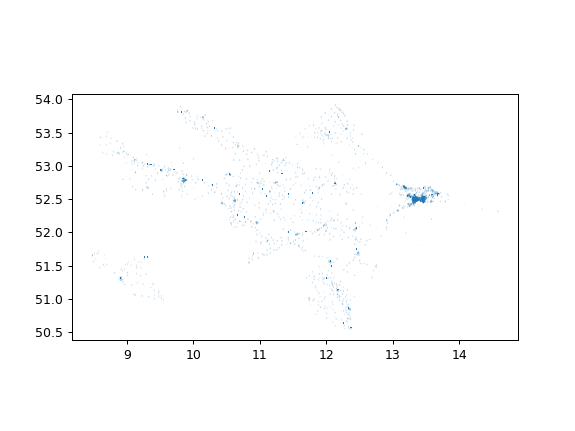

In [7]:
radius=3000
plot_radius=100
theta=60

network["line"] = network.apply(lambda row: cell2line(row.Latitude, row.Longitude, row.Azimuth, radius), axis=1)
network["toplot"] = network.apply(lambda row: cell2line(row.Latitude, row.Longitude, row.Azimuth, plot_radius), axis=1)

gpd.GeoDataFrame(network, geometry='toplot').plot()

In [9]:
def cell2beam(lat, lon, azimuth, radius, theta):
    '''Creates a LineString object in thre direction of 
    azimuth and length of radius with beamwidth of theta'''
    
    lat_scale, lon_scale = latlonscale(lat,lon)
    
    return LineString([(lon + radius*math.cos((azimuth-theta/2)*math.pi/180)/lon_scale
                        ,lat + radius*math.sin((azimuth-theta/2)*math.pi/180)/lat_scale),
                        (lon, lat)
                        ,(lon + radius*math.cos((azimuth+theta/2)*math.pi/180)/lon_scale
                        ,lat + radius*math.sin((azimuth+theta/2)*math.pi/180)/lat_scale)])

<IPython.core.display.Javascript object>


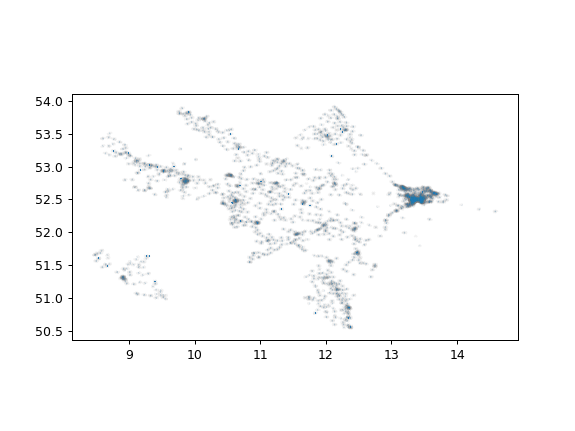

In [10]:
network["beam"] = network.apply(lambda row: cell2beam(row.Latitude, row.Longitude, row.Azimuth, radius, theta), axis=1)

ax = gpd.GeoDataFrame(network, geometry='beam').plot(color="gray", alpha=0.1)
gpd.GeoDataFrame(network, geometry='toplot').plot(ax=ax)


In [11]:
network.head()

,Cellid,CellName,Siteid,SiteName,Frequency,Power,Azimuth,CellParam1,CellParam2,CellParam3,...,CellParam6,CellParam7,CellParam8,CellParam9,KPI_x,Longitude,Latitude,line,toplot,beam
0,4960,Cell_4960,1704,Site_1704,Layer1,42,50,AA,250,549,...,68,39,9,11,2.901021,14.583308,52.316767,"LINESTRING (14.583308 52.316767, 14.6116777855...","LINESTRING (14.583308 52.316767, 14.5842536595...",LINESTRING (14.62478185193485 52.3259945831365...
1,4961,Cell_4961,1704,Site_1704,Layer1,42,120,BA,226,544,...,13,59,27,81,2.901021,14.583308,52.316767,"LINESTRING (14.583308 52.316767, 14.5612402243...","LINESTRING (14.583308 52.316767, 14.5825724074...","LINESTRING (14.583308 52.34374664817756, 14.58..."
2,4962,Cell_4962,1704,Site_1704,Layer1,42,250,CB,424,431,...,45,56,41,60,2.867531,14.583308,52.316767,"LINESTRING (14.583308 52.316767, 14.5682127523...","LINESTRING (14.583308 52.316767, 14.5828048250...",LINESTRING (14.54949820613053 52.2994248164377...
3,5082,Cell_5082,1742,Site_1742,Layer1,42,110,CB,124,177,...,98,94,21,12,2.867531,14.342583,52.349111,"LINESTRING (14.342583 52.349111, 14.3274767097...","LINESTRING (14.342583 52.349111, 14.3420794569...",LINESTRING (14.35025266457341 52.3756807666988...
4,5083,Cell_5083,1742,Site_1742,Layer1,42,220,AA,367,463,...,85,10,39,3,2.867531,14.342583,52.349111,"LINESTRING (14.342583 52.349111, 14.3087484731...","LINESTRING (14.342583 52.349111, 14.3414551824...",LINESTRING (14.29908617074223 52.3444260332598...


![dot](img\dot.jpg)

In [12]:
def relativeazimuth(lat1, lon1, az1, lat2, lon2, az2):
        
    lat_scale, lon_scale = latlonscale(lat1, lon1)
    hypot = math.hypot((lat2-lat1)*lat_scale, (lon2-lon1)*lon_scale)
    
    ax1 = (lon2-lon1)*lon_scale/hypot
    ay1 = (lat2-lat1)*lat_scale/hypot
    
    lat_scale, lon_scale = latlonscale(lat2, lon2)
    
    ax2 = (lon1-lon2)*lon_scale/math.hypot((lat1-lat2)*lat_scale,(lon1-lon2)*lon_scale)
    ay2 = (lat1-lat2)*lat_scale/math.hypot((lat1-lat2)*lat_scale,(lon1-lon2)*lon_scale)
    
    x1 = math.sin(az1*math.pi/180)
    y1 = math.cos(az1*math.pi/180)
    
    x2 = math.sin(az2*math.pi/180)
    y2 = math.cos(az2*math.pi/180)
    
    return (ax1*x1+ay1*y1+ax2*x2+ay2*y2)-math.pow(hypot/10000,2)

In [13]:
origin = gpd.GeoDataFrame(network, geometry='beam').iloc[[1500]]
origin

,Cellid,CellName,Siteid,SiteName,Frequency,Power,Azimuth,CellParam1,CellParam2,CellParam3,...,CellParam6,CellParam7,CellParam8,CellParam9,KPI_x,Longitude,Latitude,line,toplot,beam
1500,2891,Cell_2891,948,Site_948,Layer2,45,260,BA,250,388,...,36,2,98,54,1.467471,13.345017,52.487047,"LINESTRING (13.345017 52.487047, 13.3373233056...","LINESTRING (13.345017 52.487047, 13.3447605435...",LINESTRING (13.31653751078502 52.4663793904362...


In [14]:
def cell2poly(lat, lon, azimuth, radius, theta):
    '''Creates a LineString object in thre direction of 
    azimuth and length of radius with beamwidth of theta'''
    
    lat_scale, lon_scale = latlonscale(lat,lon)
    
    return Polygon([(lon + radius*math.cos((azimuth-theta/2)*math.pi/180)/lon_scale
                        ,lat + radius*math.sin((azimuth-theta/2)*math.pi/180)/lat_scale),
                        (lon, lat)
                        ,(lon + radius*math.cos((azimuth+theta/2)*math.pi/180)/lon_scale
                        ,lat + radius*math.sin((azimuth+theta/2)*math.pi/180)/lat_scale)])

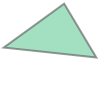

In [15]:
beam = cell2poly(origin.Latitude, origin.Longitude, origin.Azimuth, radius, theta)
beam

In [16]:
network["intersects"] = network.apply(lambda row: beam.intersects(row["beam"]), axis =1)

In [17]:
network["relative"] = network.apply(lambda row: relativeazimuth(origin.Latitude, origin.Longitude, origin.Azimuth,
                                                      row.Latitude, row.Longitude, row.Azimuth), axis =1)

<IPython.core.display.Javascript object>


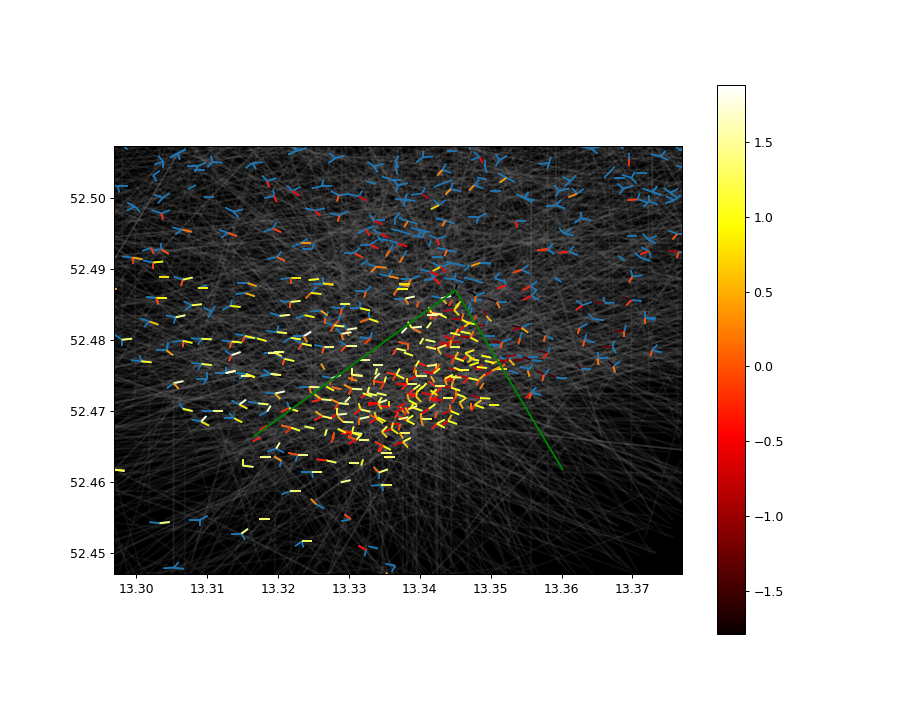

In [18]:
df = gpd.GeoDataFrame(network, geometry='beam')
ax = df.plot(alpha=0.1, color="gray")
ax.set_facecolor('k')
df.set_geometry("toplot").plot(ax=ax)
df[df["intersects"]].set_geometry("toplot").plot(ax=ax, column="relative",legend =True, cmap="hot")
gpd.GeoDataFrame(origin, geometry='beam').plot(ax=ax, color="green")

<IPython.core.display.Javascript object>


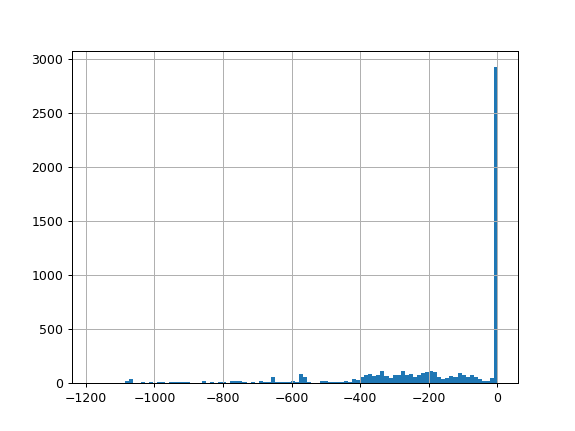

In [19]:
plt.figure()
network.relative.hist(bins=100)

In [ ]:
lat_scale, lon_scale = latlonscale(origin.Latitude,origin.Longitude)

In [ ]:

network["hypotenus"]=network.apply(lambda row: math.hypot((row.Latitude-origin.Latitude)*lat_scale
                                , (row.Longitude-origin.Longitude)*lon_scale), axis=1)


In [ ]:
plt.figure()
network.hypotenus.hist(bins=100)